In [3]:
(require '[clojupyter.javascript.alpha :as cjp-js])
(require '[clojupyter.display :as display])
(require '[clojupyter.misc.helper :as helper])
(require '[clojure.data.json :as json])
(helper/add-dependencies '[org.clojure/data.csv "1.0.0"])
(require '[clojure.data.csv :as csv])
(helper/add-dependencies '[metasoarous/oz "1.5.6"])
(require '[oz.notebook.clojupyter :as oz])
(require '[clojure.java.io :as io])
(require '[clojure.pprint :as pp])
(helper/add-dependencies '[clojure.java-time "0.3.2"])
(require '[java-time :as t])
(require '[clojure.edn :as edn])
(helper/add-dependencies '[panthera "0.1-alpha.13"])
(require '[libpython-clj.python :as py])
(require '[panthera.panthera :as pt])

nil

In [4]:
;; use panthera html display
(defn show
  [obj]
  (display/html
    (py/call-attr obj "to_html")))

(defn show-table
  [m]
  (-> m
      pt/data-frame
      show))

(show-table [{:a 1 :b 2} {:a 3 :b 4}])

,a,b
0,1,2
1,3,4


# Summary

By the end of this chapter, we're going to have downloaded all of Canada's weather data for 2012, and saved it to a CSV. 

We'll do this by downloading it one month at a time, and then combining all the months together.

Here's the temperature every hour for 2012!

In [22]:
;; Python
;; weather_2012_final = pd.read_csv('../data/weather_2012.csv', index_col='Date/Time')

(def fixed-data
    (with-open [reader (io/reader "../data/weather_2012.csv")]
      (doall
        (csv/read-csv reader))))

(defn blank->nil [s]
   (when-not (#{""} s) s))

(defn csv-data->maps [csv-data]
  (map zipmap
       (->> (first csv-data) ;; First row is the header
            (map keyword) ;; Drop if you want string keys instead
            repeat)
       (->> (rest csv-data)
            (map #(map blank->nil %))))) ;; Drop if you want blank strings to stay

(defn col-parser [col-key]
    (if (= :Date/Time col-key)
         identity
         edn/read-string))

(def weather-2012-final
    (->> fixed-data
         csv-data->maps
        (map #(into {} (map (fn [[k v]] [k ((col-parser k) v)]) %))))) ;; Apply each parser to columns

(->> weather-2012-final
     (take 5)
     show-table)

,Time,Temp (C),Dew Point Temp (C),Rel Hum (%),h),Visibility (km),Stn Press (kPa),Weather
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,Freezing
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,Freezing
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [23]:
;; weather_2012_final['Temp (C)'].plot(figsize=(15, 6))

(oz/view!
  {:data {:values weather-2012-final}
  :mark "line"
  :encoding {:x {:field :Date/Time
                 :type "temporal"
                 :sort false}
             :y {:field (keyword "Temp (C)")
                 :type "quantitative"}}
  :width 800})

# 5.1 Downloading one month of weather data

When playing with the cycling data, I wanted temperature and precipitation data to find out if people like biking when it's raining. So I went to the site for [Canadian historical weather data](http://climate.weather.gc.ca/index_e.html#access), and figured out how to get it automatically.

Here we're going to get the data for March 2012, and clean it up

Here's an URL template you can use to get data in Montreal. 

In [26]:
;; Python
;; url_template = "http://climate.weather.gc.ca/climateData/bulkdata_e.html?format=csv&stationID=5415&Year={year}&Month={month}&timeframe=1&submit=Download+Data"

(def url-template "http://climate.weather.gc.ca/climateData/bulkdata_e.html?format=csv&stationID=5415&Year=%d&Month=%d&timeframe=1&submit=Download+Data")

#'user/url-template

To get the data for March 2013, we need to format it with `month=3, year=2012`.

In [29]:
;; Python 
;; url = url_template.format(month=3, year=2012)

(def url (format url-template 2012 3))
url

"http://climate.weather.gc.ca/climateData/bulkdata_e.html?format=csv&stationID=5415&Year=2012&Month=3&timeframe=1&submit=Download+Data"

In [30]:
;; Python
;; weather_mar2012 = pd.read_csv(url, skiprows=15, index_col='Date/Time', parse_dates=True, encoding='latin1', header=True)

(def raw-string (slurp url))

#'user/raw-string

In [32]:
(->> raw-string)

"<!DOCTYPE HTML PUBLIC \"-//IETF//DTD HTML 2.0//EN\">\n<html><head>\n<title>301 Moved Permanently</title>\n</head><body>\n<h1>Moved Permanently</h1>\n<p>The document has moved <a href=\"https://climate.weather.gc.ca/climateData/bulkdata_e.html?format=csv&amp;stationID=5415&amp;Year=2012&amp;Month=3&amp;timeframe=1&amp;submit=Download+Data\">here</a>.</p>\n</body></html>\n"

This is super great! We can just use the same `read_csv` function as before, and just give it a URL as a filename. Awesome.

There are 16 rows of metadata at the top of this CSV, but pandas knows CSVs are weird, so there's a `skiprows` options. We parse the dates again, and set 'Date/Time' to be the index column. Here's the resulting dataframe.

In [5]:
weather_mar2012

,Year,Month,Day,Time,Data Quality,Temp (Â°C),Temp Flag,Dew Point Temp (Â°C),Dew Point Temp Flag,Rel Hum (%),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
Date/Time,,,,,,,,,,,,,,,,,,,,,
2012-03-01 00:00:00,2012,3,1,00:00,,-5.5,NaN,-9.7,NaN,72,...,NaN,4.0,NaN,100.97,NaN,NaN,NaN,-13,NaN,Snow
2012-03-01 01:00:00,2012,3,1,01:00,,-5.7,NaN,-8.7,NaN,79,...,NaN,2.4,NaN,100.87,NaN,NaN,NaN,-13,NaN,Snow
2012-03-01 02:00:00,2012,3,1,02:00,,-5.4,NaN,-8.3,NaN,80,...,NaN,4.8,NaN,100.80,NaN,NaN,NaN,-13,NaN,Snow
2012-03-01 03:00:00,2012,3,1,03:00,,-4.7,NaN,-7.7,NaN,79,...,NaN,4.0,NaN,100.69,NaN,NaN,NaN,-12,NaN,Snow
2012-03-01 04:00:00,2012,3,1,04:00,,-5.4,NaN,-7.8,NaN,83,...,NaN,1.6,NaN,100.62,NaN,NaN,NaN,-14,NaN,Snow
2012-03-01 05:00:00,2012,3,1,05:00,,-5.3,NaN,-7.9,NaN,82,...,NaN,2.4,NaN,100.58,NaN,NaN,NaN,-14,NaN,Snow
2012-03-01 06:00:00,2012,3,1,06:00,,-5.2,NaN,-7.8,NaN,82,...,NaN,4.0,NaN,100.57,NaN,NaN,NaN,-14,NaN,Snow
2012-03-01 07:00:00,2012,3,1,07:00,,-4.9,NaN,-7.4,NaN,83,...,NaN,1.6,NaN,100.59,NaN,NaN,NaN,-13,NaN,Snow
2012-03-01 08:00:00,2012,3,1,08:00,,-5.0,NaN,-7.5,NaN,83,...,NaN,1.2,NaN,100.59,NaN,NaN,NaN,-13,NaN,Snow


Let's plot it!

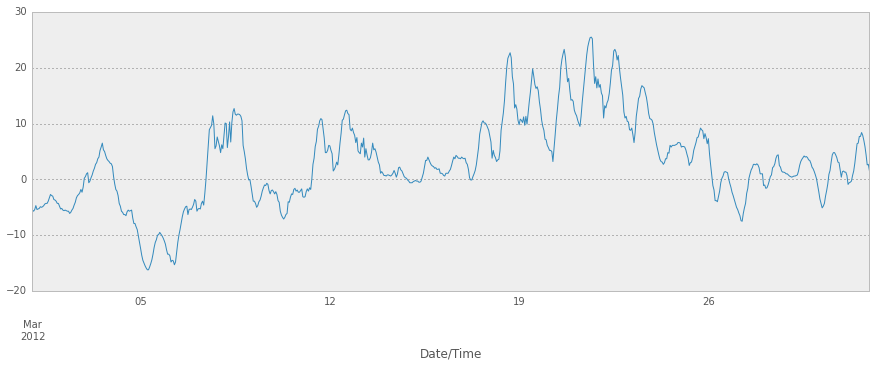

In [6]:
weather_mar2012[u"Temp (\xc2\xb0C)"].plot(figsize=(15, 5))

Notice how it goes up to 25° C in the middle there? That was a big deal. It was March, and people were wearing shorts outside. 

And I was out of town and I missed it. Still sad, humans.

I had to write `'\xb0'` for that degree character °. Let's fix up the columns. We're going to just print them out, copy, and fix them up by hand.

In [7]:
weather_mar2012.columns = [
    u'Year', u'Month', u'Day', u'Time', u'Data Quality', u'Temp (C)', 
    u'Temp Flag', u'Dew Point Temp (C)', u'Dew Point Temp Flag', 
    u'Rel Hum (%)', u'Rel Hum Flag', u'Wind Dir (10s deg)', u'Wind Dir Flag', 
    u'Wind Spd (km/h)', u'Wind Spd Flag', u'Visibility (km)', u'Visibility Flag',
    u'Stn Press (kPa)', u'Stn Press Flag', u'Hmdx', u'Hmdx Flag', u'Wind Chill', 
    u'Wind Chill Flag', u'Weather']

You'll notice in the summary above that there are a few columns which are are either entirely empty or only have a few values in them. Let's get rid of all of those with `dropna`.

The argument `axis=1` to `dropna` means "drop columns", not rows", and `how='any'` means "drop the column if any value is null". 

This is much better now -- we only have columns with real data.

In [8]:
weather_mar2012 = weather_mar2012.dropna(axis=1, how='any')
weather_mar2012[:5]

,Year,Month,Day,Time,Data Quality,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
Date/Time,,,,,,,,,,,,
2012-03-01 00:00:00,2012,3,1,00:00,,-5.5,-9.7,72,24,4.0,100.97,Snow
2012-03-01 01:00:00,2012,3,1,01:00,,-5.7,-8.7,79,26,2.4,100.87,Snow
2012-03-01 02:00:00,2012,3,1,02:00,,-5.4,-8.3,80,28,4.8,100.80,Snow
2012-03-01 03:00:00,2012,3,1,03:00,,-4.7,-7.7,79,28,4.0,100.69,Snow
2012-03-01 04:00:00,2012,3,1,04:00,,-5.4,-7.8,83,35,1.6,100.62,Snow


The Year/Month/Day/Time columns are redundant, though, and the Data Quality column doesn't look too useful. Let's get rid of those.

The `axis=1` argument means "Drop columns", like before. The default for operations like `dropna` and `drop` is always to operate on rows.

In [9]:
weather_mar2012 = weather_mar2012.drop(['Year', 'Month', 'Day', 'Time', 'Data Quality'], axis=1)
weather_mar2012[:5]

,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
Date/Time,,,,,,,
2012-03-01 00:00:00,-5.5,-9.7,72,24,4.0,100.97,Snow
2012-03-01 01:00:00,-5.7,-8.7,79,26,2.4,100.87,Snow
2012-03-01 02:00:00,-5.4,-8.3,80,28,4.8,100.80,Snow
2012-03-01 03:00:00,-4.7,-7.7,79,28,4.0,100.69,Snow
2012-03-01 04:00:00,-5.4,-7.8,83,35,1.6,100.62,Snow


Awesome! We now only have the relevant columns, and it's much more manageable.

# 5.2 Plotting the temperature by hour of day

This one's just for fun -- we've already done this before, using groupby and aggregate! We will learn whether or not it gets colder at night. Well, obviously. But let's do it anyway.

<bound method DataFrame.head of                      Temp (C)
Date/Time                    
2012-03-01 00:00:00      -5.5
2012-03-01 01:00:00      -5.7
2012-03-01 02:00:00      -5.4
2012-03-01 03:00:00      -4.7
2012-03-01 04:00:00      -5.4
2012-03-01 05:00:00      -5.3
2012-03-01 06:00:00      -5.2
2012-03-01 07:00:00      -4.9
2012-03-01 08:00:00      -5.0
2012-03-01 09:00:00      -4.9
2012-03-01 10:00:00      -4.7
2012-03-01 11:00:00      -4.4
2012-03-01 12:00:00      -4.3
2012-03-01 13:00:00      -4.3
2012-03-01 14:00:00      -3.9
2012-03-01 15:00:00      -3.3
2012-03-01 16:00:00      -2.7
2012-03-01 17:00:00      -2.9
2012-03-01 18:00:00      -3.0
2012-03-01 19:00:00      -3.6
2012-03-01 20:00:00      -3.7
2012-03-01 21:00:00      -3.9
2012-03-01 22:00:00      -4.3
2012-03-01 23:00:00      -4.3
2012-03-02 00:00:00      -4.8
2012-03-02 01:00:00      -5.3
2012-03-02 02:00:00      -5.2
2012-03-02 03:00:00      -5.5
2012-03-02 04:00:00      -5.6
2012-03-02 05:00:00      -5.5
...     

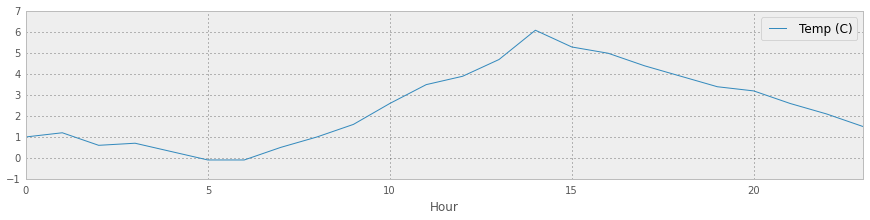

In [10]:
temperatures = weather_mar2012[[u'Temp (C)']].copy()
print(temperatures.head)
temperatures.loc[:,'Hour'] = weather_mar2012.index.hour
temperatures.groupby('Hour').aggregate(np.median).plot()

So it looks like the time with the highest median temperature is 2pm. Neat.

# 5.3 Getting the whole year of data

Okay, so what if we want the data for the whole year? Ideally the API would just let us download that, but I couldn't figure out a way to do that.

First, let's put our work from above into a function that gets the weather for a given month. 

I noticed that there's an irritating bug where when I ask for January, it gives me data for the previous year, so we'll fix that too. [no, really. You can check =)]

In [11]:
def download_weather_month(year, month):
    if month == 1:
        year += 1
    url = url_template.format(year=year, month=month)
    weather_data = pd.read_csv(url, skiprows=15, index_col='Date/Time', parse_dates=True, header=True)
    weather_data = weather_data.dropna(axis=1)
    weather_data.columns = [col.replace('\xb0', '') for col in weather_data.columns]
    weather_data = weather_data.drop(['Year', 'Day', 'Month', 'Time', 'Data Quality'], axis=1)
    return weather_data

We can test that this function does the right thing:

In [12]:
download_weather_month(2012, 1)[:5]

,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
Date/Time,,,,,,,
2013-01-01 00:00:00,-1.0,-1.7,95,35,6.4,99.89,Snow
2013-01-01 01:00:00,-2.0,-5.1,79,35,16.1,99.93,Mainly Clear
2013-01-01 02:00:00,-2.7,-6.0,78,28,19.3,100.08,Snow
2013-01-01 03:00:00,-5.6,-11.7,62,30,25.0,100.21,Clear
2013-01-01 04:00:00,-7.7,-12.6,68,35,19.3,100.32,Mainly Clear


Now we can get all the months at once. This will take a little while to run.

In [13]:
data_by_month = [download_weather_month(2012, i) for i in range(1, 13)]

Once we have this, it's easy to concatenate all the dataframes together into one big dataframe using `pd.concat`. And now we have the whole year's data!

In [14]:
weather_2012 = pd.concat(data_by_month)
weather_2012

,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
Date/Time,,,,,,,
2013-01-01 00:00:00,-1.0,-1.7,95,35,6.4,99.89,Snow
2013-01-01 01:00:00,-2.0,-5.1,79,35,16.1,99.93,Mainly Clear
2013-01-01 02:00:00,-2.7,-6.0,78,28,19.3,100.08,Snow
2013-01-01 03:00:00,-5.6,-11.7,62,30,25.0,100.21,Clear
2013-01-01 04:00:00,-7.7,-12.6,68,35,19.3,100.32,Mainly Clear
2013-01-01 05:00:00,-9.7,-14.8,66,33,25.0,100.47,Clear
2013-01-01 06:00:00,-11.1,-17.0,62,30,25.0,100.65,Clear
2013-01-01 07:00:00,-12.2,-17.2,66,20,25.0,100.78,Clear
2013-01-01 08:00:00,-13.0,-17.7,68,13,24.1,100.87,Clear


# 5.4 Saving to a CSV

It's slow and unnecessary to download the data every time, so let's save our dataframe for later use!

In [15]:
weather_2012.to_csv('../data/weather_2012.csv')

And we're done!